<a href="https://colab.research.google.com/github/lagunerio/SpartaCodingclub2021/blob/main/HW3/GAN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip uninstall -y keras
!pip install keras

In [11]:
import keras
from keras import layers
from tensorflow.keras import optimizers
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import copy
from keras.utils.vis_utils import plot_model

# 데이터 준비

In [ ]:
from google.colab import files
uploaded = files.upload()

In [12]:
df_final = pd.read_csv("BAC.csv")
df_final.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-09-21,24.570000,24.780001,24.030001,24.469999,23.973949,75218600
1,2020-09-22,24.270000,24.600000,23.809999,23.940001,23.454697,68665300
2,2020-09-23,24.100000,24.260000,23.260000,23.260000,22.788481,59950300
3,2020-09-24,23.379999,23.820000,22.950001,23.340000,22.866859,53570700
4,2020-09-25,23.280001,23.549999,23.129999,23.490000,23.013819,42111300


# 함수 1. 한개의 데이터를 Input과 Y(예측)값으로 나누어주기

In [5]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# 함수 2. 데이터를 가져와서 전처리, Train/Test로 나누어주기

In [17]:
def data_preprocessing(step_size, data_filename):
	'''load data and transform data into trainset and testset
		features: O,H,L,C 
		'''
	#df_final = pd.read_csv('results_AAPL_new.csv')
	df_final = pd.read_csv(data_filename)
	
  #df_final.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Pct_change_raw', 'Compound_multiplied_raw']
	df_final.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
	
  # avoid the data leakage problem
	#df_final['Pct_change'] = df_final['Pct_change_raw'].shift(1)
	#df_final.drop(['Pct_change_raw'], axis=1, inplace=True)
	#df_final['Compound_multiplied'] = df_final['Compound_multiplied_raw'].shift(1)
	#df_final.drop(['Compound_multiplied_raw'], axis=1, inplace=True)
	df_final.dropna(axis=0, how='any', inplace=True)
	dataset = df_final
	dataset['Date'] = pd.to_datetime(dataset.Date, format='%Y-%m-%d')
	dataset.index = dataset['Date']
	dataset = dataset.sort_index(ascending=True, axis=0)
	dataset.drop(['Date'], axis=1, inplace=True)
	
	values = dataset.values #67*6
	# ensure all data is float
	values = values.astype('float32')
	# normalize features
	scaler = MinMaxScaler(feature_range=(0, 1))
	scaled = scaler.fit_transform(values)
	
	# frame as supervised learning
	reframed = series_to_supervised(scaled, step_size, 1)  # 5
	print(reframed.shape)  # 
	# split into train and test sets
	values = reframed.values
	
	n_train_days = 61-1
	train = values[:n_train_days, :]
	test = values[n_train_days:, :]
	
	return train, test, scaler

# 함수 3. Generator

In [7]:
step_size = 5
feature_num = 6

generator_input = keras.Input(shape=(step_size,feature_num))
x = layers.LSTM(75,return_sequences=True)(generator_input)
x = layers.Dropout(0.2)(x)
x = layers.LSTM(25)(x)
x = layers.Dense(1)(x)
x = layers.LeakyReLU()(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 6)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 5, 75)             24600     
_________________________________________________________________
dropout (Dropout)            (None, 5, 75)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 25)                10100     
_________________________________________________________________
dense (Dense)                (None, 1)                 26        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1)                 0         
Total params: 34,726
Trainable params: 34,726
Non-trainable params: 0
_________________________________________________________

# 함수 4. Discriminator

In [8]:
discriminator_input = layers.Input(shape=(step_size+1,1))
y = layers.Dense(72)(discriminator_input)
y = layers.LeakyReLU(alpha=0.05)(y)
y = layers.Dense(100)(y)
y = layers.LeakyReLU(alpha=0.05)(y)
y = layers.Dense(10)(y)
y = layers.LeakyReLU(alpha=0.05)(y)
y = layers.Dense(1,activation='sigmoid')(y)
discriminator = keras.models.Model(discriminator_input, y)
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 6, 1)]            0         
_________________________________________________________________
dense_1 (Dense)              (None, 6, 72)             144       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6, 72)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 6, 100)            7300      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6, 100)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 6, 10)             1010      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 6, 10)             0   

# Generator & Discriminator 실행

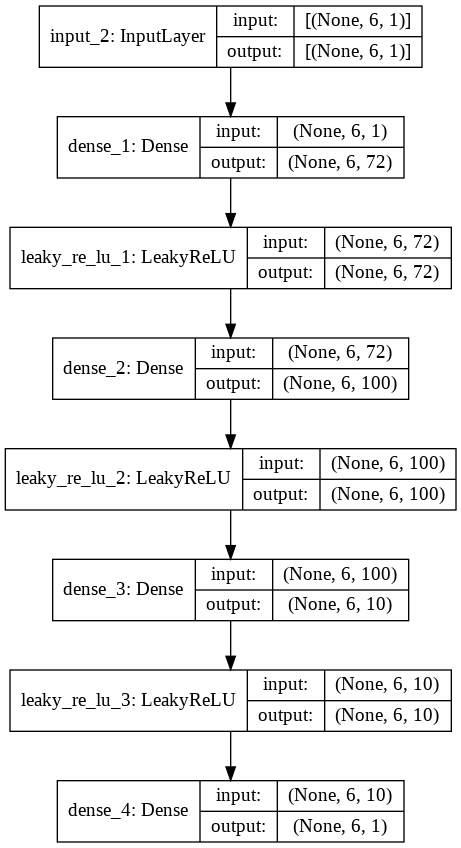

In [9]:
plot_model(generator, to_file='model_G.png', show_shapes=True, show_layer_names=True)
plot_model(discriminator, to_file='model_D.png', show_shapes=True, show_layer_names=True)

# 함수 5. Optimizer

In [14]:
discriminator_optimizer = optimizers.RMSprop(lr=8e-4, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

# Optimizer정의 
discriminator.trainable = False
gan_input = keras.Input(shape=(step_size, feature_num))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)
gan_optimizer = optimizers.RMSprop(lr=4e-4, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# 함수 6. 데이터 Reshape

In [18]:
# PREPARATION OF TIME SERIES DATASET
train,test,scaler = data_preprocessing(step_size, "BAC.csv")
# split into input and outputs
n_obs = step_size * feature_num
train_X, train_Y = train[:, :n_obs], train[:, -feature_num] #choose the first feature,namely 'open price'
test_X, test_Y = test[:, :n_obs], test[:, -feature_num]  # !!!!!!!!!!!!!!!
print(train_X.shape, len(train_X), train_Y.shape) #train_X 280*30,train_Y  280*6
# reshape input to be 3D [samples, timesteps, features]
trainX = train_X.reshape((train_X.shape[0], step_size, feature_num))
testX = test_X.reshape((test_X.shape[0], step_size, feature_num))

(246, 36)
(60, 30) 60 (60,)


# 파라미터 정의

In [19]:
#파라메터정의 
iterations = 61-1
batch_size = 1
start = 0
final = []

# RUN!!

In [20]:
#이터레이션 시작 
for step in range(iterations):
	print(step)
	temp_X = copy.deepcopy(trainX[step])
	temp_X = temp_X.reshape(batch_size,step_size,feature_num)
	temp_Y = copy.deepcopy(train_Y[step])
	temp_Y = temp_Y.reshape(batch_size,1)
	predictions = generator.predict(temp_X)
	# discrriminator 
	for i in range(25):
		aaa = trainX[step]
		input_f = np.concatenate([np.transpose(np.array([aaa[:,0]])), predictions], 0)
		input_r = np.concatenate([np.transpose(np.array([aaa[:,0]])), temp_Y], 0)
		input = np.concatenate([[input_f],[input_r]])
		labels = np.concatenate([[np.ones((6, 1))], [np.zeros((6, 1))]])
		d_loss = discriminator.train_on_batch(input, labels)
	# generator 
	for i in range(5):
		misleading_targets = np.zeros((batch_size, 1))
		a_loss = gan.train_on_batch(temp_X, [misleading_targets])
	final.append(predictions[0])
final = np.concatenate((np.array(final), train_X[:, -5:]), axis=1)
final2 = np.concatenate((np.transpose(np.array([train_Y])), train_X[:, -5:]), axis=1)
int1 = scaler.inverse_transform(final)
int2 = scaler.inverse_transform(final2)
MAPE_O1 = np.mean(np.abs((int2[:,0] - int1[:,0]) / int2[:,0]))
print('training result:',MAPE_O1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
training result: 4.477644
